<a href="https://colab.research.google.com/github/shipley7/fifa/blob/main/FIFA.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
# Necessary imports
import pandas as pd
import numpy as np
import matplotlib.ticker as mtick
import matplotlib.pyplot as plt
from sklearn.preprocessing import OneHotEncoder
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, precision_recall_curve, precision_score, recall_score
from sklearn import svm
from sklearn.model_selection import RandomizedSearchCV, GroupKFold
from sklearn.pipeline import Pipeline

In [2]:
df = pd.read_csv("combined_match_data.csv") # getting the data
df.head() # printing out the data

,index,Player,#,Nation,Pos,Age,Min,Gls,Ast,PK,...,AvgLen.1,Opp,Stp,Stp%,#OPA,AvgDist,home,game_id,top100,source_file
0,0,14 Players,NaN,NaN,NaN,NaN,990.0,3.0,2.0,1.0,...,NaN,NaN,NaN,NaN,NaN,NaN,1,0,0,bundesliga_2017-2018_player_data.csv
1,1,Arjen Robben,10.0,nl NED,RW,33-207,30.0,0.0,0.0,0.0,...,NaN,NaN,NaN,NaN,NaN,NaN,1,0,0,bundesliga_2017-2018_player_data.csv
2,2,Arturo Vidal,23.0,cl CHI,LM,30-088,90.0,0.0,1.0,0.0,...,NaN,NaN,NaN,NaN,NaN,NaN,1,0,0,bundesliga_2017-2018_player_data.csv
3,3,Corentin Tolisso,24.0,fr FRA,RM,23-015,90.0,1.0,0.0,0.0,...,NaN,NaN,NaN,NaN,NaN,NaN,1,0,0,bundesliga_2017-2018_player_data.csv
4,4,David Alaba,27.0,at AUT,LB,25-055,90.0,0.0,0.0,0.0,...,NaN,NaN,NaN,NaN,NaN,NaN,1,0,0,bundesliga_2017-2018_player_data.csv


In [3]:
df = df[df["Player"].str.contains("Players")==False] # removing excess rows that have no player information
df = df.drop(['index', "#"], axis = 1) # index and player number have no impact on anything
df[["Age Years", "Age Days"]] = (df.Age.str.split("-", expand = True)).apply(pd.to_numeric) # splitting age column into two other columns
df[["league", "season"]] = df["source_file"].replace("_player_data.csv", "", regex = True).str.split("_", expand = True) # splitting the source file into a league and season
df["season"] = (df["season"].str[-4:].astype(int)) # season will be an integer representing the year the season ended
df = pd.get_dummies(df, columns=["league"]) # league will be a boolean variable representing which leage we are using
df = df.drop(['Age','source_file', "game_id"], axis = 1) # removing age, source file, and game id as they are no longer needed
df = df.fillna(0) # filling any NA with 0
df # just to check

,Player,Nation,Pos,Min,Gls,Ast,PK,PKatt,Sh,SoT,...,home,top100,Age Years,Age Days,season,league_bundesliga,league_la-liga,league_ligue-1,league_premier-league,league_serie-a
1,Arjen Robben,nl NED,RW,30.0,0.0,0.0,0.0,0.0,1.0,1.0,...,1,0,33.0,207.0,2018,True,False,False,False,False
2,Arturo Vidal,cl CHI,LM,90.0,0.0,1.0,0.0,0.0,1.0,0.0,...,1,0,30.0,88.0,2018,True,False,False,False,False
3,Corentin Tolisso,fr FRA,RM,90.0,1.0,0.0,0.0,0.0,4.0,3.0,...,1,0,23.0,15.0,2018,True,False,False,False,False
4,David Alaba,at AUT,LB,90.0,0.0,0.0,0.0,0.0,0.0,0.0,...,1,0,25.0,55.0,2018,True,False,False,False,False
5,Franck Ribéry,fr FRA,LW,76.0,0.0,0.0,0.0,0.0,0.0,0.0,...,1,0,34.0,133.0,2018,True,False,False,False,False
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
452035,Ondrej Duda,sk SVK,DM,90.0,0.0,1.0,0.0,0.0,2.0,0.0,...,0,0,30.0,171.0,2025,False,False,False,False,True
452036,Paweł Dawidowicz,pl POL,DM,90.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0,0,30.0,5.0,2025,False,False,False,False,True
452037,Simone Perilli,it ITA,GK,90.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0,0,30.0,138.0,2025,False,False,False,False,True
452038,Suat Serdar,de GER,DM,80.0,1.0,0.0,0.0,0.0,1.0,1.0,...,0,0,28.0,44.0,2025,False,False,False,False,True


In [4]:
# splitting into keepers and outfielders since they all have different statistics
keepers = df[df["Pos"] == "GK"]
outfielders = df[df["Pos"] != "GK"]

In [5]:
# for keepers, removing everything that a keeper doesn't normally do
keepers = keepers.drop(["Pos", 'Gls', 'Ast', 'PK', 'PKatt', 'Sh',
       'SoT', 'Touches', 'Tkl', 'Int', 'Blocks', 'xG', 'npxG',
       'xAG', 'SCA', 'GCA', 'Cmp_x', 'Att_x', 'Cmp%_x', 'PrgP', 'Carries',
       'PrgC', 'Att_x.1', 'Succ'], axis = 1)
keepers

,Player,Nation,Min,CrdY,CrdR,SoTA,GA,Saves,Save%,PSxG,...,home,top100,Age Years,Age Days,season,league_bundesliga,league_la-liga,league_ligue-1,league_premier-league,league_serie-a
13,Sven Ulreich,de GER,90.0,0.0,0.0,4.0,1.0,3.0,75.0,0.9,...,1,0,29.0,15.0,2018,True,False,False,False,False
19,Bernd Leno,de GER,90.0,0.0,0.0,8.0,3.0,5.0,75.0,3.5,...,0,0,25.0,167.0,2018,True,False,False,False,False
36,Koen Casteels,be BEL,90.0,0.0,0.0,5.0,3.0,2.0,40.0,1.9,...,1,0,25.0,55.0,2018,True,False,False,False,False
56,Roman Bürki,ch SUI,90.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0,0,26.0,278.0,2018,True,False,False,False,False
70,Rune Jarstein,no NOR,90.0,0.0,0.0,2.0,0.0,2.0,100.0,0.1,...,1,0,32.0,324.0,2018,True,False,False,False,False
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
451966,Michele Di Gregorio,it ITA,90.0,0.0,0.0,5.0,2.0,3.0,60.0,1.4,...,0,0,27.0,302.0,2025,False,False,False,False,True
451981,Marco Carnesecchi,it ITA,90.0,0.0,0.0,10.0,3.0,7.0,70.0,3.0,...,1,0,24.0,328.0,2025,False,False,False,False,True
452006,Zion Suzuki,jp JPN,90.0,0.0,0.0,4.0,2.0,2.0,50.0,1.9,...,0,0,22.0,277.0,2025,False,False,False,False,True
452010,Devis Vásquez,co COL,90.0,0.0,0.0,2.0,2.0,0.0,0.0,1.5,...,1,0,27.0,13.0,2025,False,False,False,False,True


In [6]:
position_dummies = outfielders.Pos.str.get_dummies(sep = ",") # since most players play mutliple positions in a match, we will have to multi-hot encode
outfielders = pd.concat([outfielders.drop(columns=["Pos"]), position_dummies], axis = 1) # combining our binary position columns with the remaining dataframe
outfielders[['AM', 'CB', 'CM', 'DF', 'DM',
       'FW', 'LB', 'LM', 'LW', 'MF', 'RB', 'RM', 'RW', 'WB']] = outfielders[['AM', 'CB', 'CM', 'DF', 'DM',
       'FW', 'LB', 'LM', 'LW', 'MF', 'RB', 'RM', 'RW', 'WB']].astype('bool') # change position to boolean (did they play this position in the match or not?)
outfielders = outfielders.drop(['SoTA', 'GA', 'Saves', 'Save%', 'PSxG',
       'Cmp_y', 'Att_y', 'Cmp%_y', 'Att (GK)', 'Thr', 'Launch%', 'AvgLen',
       'Att_y.1', 'Launch%.1', 'AvgLen.1', 'Opp', 'Stp', 'Stp%', '#OPA',
       'AvgDist', 'GK'], axis = 1) # removing keeper statistics
outfielders

,Player,Nation,Min,Gls,Ast,PK,PKatt,Sh,SoT,CrdY,...,DM,FW,LB,LM,LW,MF,RB,RM,RW,WB
1,Arjen Robben,nl NED,30.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,...,False,False,False,False,False,False,False,False,True,False
2,Arturo Vidal,cl CHI,90.0,0.0,1.0,0.0,0.0,1.0,0.0,1.0,...,False,False,False,True,False,False,False,False,False,False
3,Corentin Tolisso,fr FRA,90.0,1.0,0.0,0.0,0.0,4.0,3.0,0.0,...,False,False,False,False,False,False,False,True,False,False
4,David Alaba,at AUT,90.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,False,False,True,False,False,False,False,False,False,False
5,Franck Ribéry,fr FRA,76.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,False,False,False,False,True,False,False,False,False,False
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
452034,Nicolás Valentini,ar ARG,90.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,...,False,False,False,False,False,False,False,False,False,False
452035,Ondrej Duda,sk SVK,90.0,0.0,1.0,0.0,0.0,2.0,0.0,0.0,...,True,False,False,False,False,False,False,False,False,False
452036,Paweł Dawidowicz,pl POL,90.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,True,False,False,False,False,False,False,False,False,False
452038,Suat Serdar,de GER,80.0,1.0,0.0,0.0,0.0,1.0,1.0,0.0,...,True,False,False,False,False,False,False,False,False,False


In [7]:
# Setup window for predictions
outfielders_pred = outfielders.groupby(["Player", "season"]).agg({
    'Min':'sum', 'Gls':'sum', 'Ast':'sum', 'PK':'sum', 'PKatt':'sum', 'Sh':'sum', 'SoT':'sum', 'CrdY':'sum', 'CrdR':'sum',
       'Touches':'sum', 'Tkl':'sum', 'Int':'sum', 'Blocks':'sum', 'xG':'sum', 'npxG':'sum', 'xAG':'sum', 'SCA':'sum', 'GCA':'sum',
       'Cmp_x':'sum', 'Att_x':'sum', 'Cmp%_x':'mean', 'PrgP':'sum', 'Carries':'sum', 'PrgC':'sum', 'Att_x.1':'sum',
       'Succ':'sum', 'home':'sum', 'top100':'mean', 'Age Years':'mean', 'Age Days':'mean', 'league_bundesliga':'mean',
       'league_la-liga':'mean', 'league_ligue-1':'mean', 'league_premier-league':'mean',
       'league_serie-a':'mean', 'AM':'mean', 'CB':'mean', 'CM':'mean', 'DF':'mean', 'DM':'mean', 'FW':'mean', 'LB':'mean', 'LM':'mean', 'LW':'mean',
       'MF':'mean', 'RB':'mean', 'RM':'mean', 'RW':'mean', 'WB':'mean'
}).reset_index() # how we are aggregating each of the player's statistics

outfielders_pred.top100 = (outfielders_pred.top100 != 0.0).astype(int) # make our target variable binary

train_seasons = [2018, 2019, 2020, 2021, 2022, 2023, 2024] # every season except 2025 is our training data
test_season = [2025] # we will test on the most recent season
train_df = outfielders_pred[outfielders_pred['season'].isin(train_seasons)] # get a dataframe of just training data
test_df = outfielders_pred[outfielders_pred['season'].isin(test_season)] # get a dataframe of just testing data

# Setting up X_train, y_train, X_test, and y_test
# Removing unnessary columns from training set
X_train = train_df.drop(columns = ['Player', 'season', 'home', 'Age Days', 'top100', 'league_bundesliga', 'league_la-liga', 'league_ligue-1', 'league_premier-league', 'league_serie-a'])
y_train = train_df['top100']
X_test = test_df.drop(columns = ['Player', 'season', 'home', 'Age Days', 'top100', 'league_bundesliga', 'league_la-liga', 'league_ligue-1', 'league_premier-league', 'league_serie-a'])
y_test = test_df['top100']
id_train = train_df.Player.reset_index().drop("index", axis = 1)
id_test = test_df.Player.reset_index().drop("index", axis = 1)

stars = list(outfielders_pred[(outfielders_pred['top100'] != 0) & (outfielders_pred['season'] == 2025)]['Player']) # The list of outfielders in the current top 100 who we do have in our dataset (77 of them)

scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

In [8]:
# Resuable function
def predictions(model):
  y_pred = model.predict(X_test) # prediction on if the player in question will be a top 100 player (1) or not (0)
  y_pred_prob = model.predict_proba(X_test) # predicted probabilities of being a top 100 player or not
  potential_indexes = [] # list to hold the indexes of our test data who are predicted to be a star
  for i in range(len(y_pred)):
    potential_indexes.append(i) # add the index of the future top 100 player into our array
  stardom = y_pred_prob[potential_indexes, 1] # get the predicted probability of everyone who is predicted to be a future top 100 player
  rankings = []

  # highest predicted probabilities will be how we base our rankings
  for i in range(len(stardom)):
    for j in range(i + 1):
      if (stardom[j] < stardom[i]):
        temp = stardom[i]
        temp2 = potential_indexes[i]
        stardom[i] = stardom[j]
        potential_indexes[i] = potential_indexes[j]
        stardom[j] = temp
        potential_indexes[j] = temp2

  correct = 0 # see how many were succesfully identified in top 100

  for i in range(100):
    rankings.append(id_test.iloc[potential_indexes[i], 0]) # append the player's with the highest predicted probabilities into our rankings
    if str(id_test.iloc[potential_indexes[i], 0]) in stars:
      correct += 1 # increase our correct if the player here actually appears in the top 100 somewhere

  return rankings, correct # return our rankings and correctness

In [ ]:
log1 = LogisticRegression(class_weight="balanced", random_state = 42) # Logistic regression model
log1.fit(X_train, y_train) # fit the model
log1_rankings, log1_correct = predictions(log1) # get rankings and correctness

print("Balanced Players correct:", log1_correct) # 47 players were correct
print("Balanced Percentage correct:", str(log1_correct / len(stars) * 100) + "%") # 61.04% of the possible 77 players identified as true top 100s were in the top 100
print("Balanced Rankings:", log1_rankings)
print(" ")


log2 = LogisticRegression(class_weight=None, random_state = 42) # Logistic regression model
log2.fit(X_train, y_train) # fit the model
log2_rankings, log2_correct = predictions(log2) # get rankings and correctness

print("None Players correct:", log2_correct) # 43 players were correct
print("None Percentage correct:", str(log2_correct / len(stars) * 100) + "%") # 55.84% of the possible 77 players identified as true top 100s were in the top 100
print("None Rankings:", log2_rankings)


Balanced Players correct: 47
Balanced Percentage correct: 61.038961038961034%
Balanced Rankings: ['Kylian Mbappé', 'Raphinha', 'Ousmane Dembélé', 'Joshua Kimmich', 'Mohamed Salah', 'Bradley Barcola', 'Lamine Yamal', 'Michael Olise', 'Pierre Højbjerg', 'Omar Marmoush', 'Harry Kane', 'Vitinha', 'Hugo Ekitike', 'Achraf Hakimi', 'Leonardo Balerdi', 'Florian Wirtz', 'Alexander Isak', 'Luis Díaz', 'Granit Xhaka', 'Désiré Doué', 'João Neves', 'Robert Lewandowski', 'Khvicha Kvaratskhelia', 'Pau Cubarsí', 'Kim Min-jae', 'Pedri', 'Virgil van Dijk', 'Mateo Retegui', 'William Saliba', 'Cole Palmer', 'Joško Gvardiol', 'Mason Greenwood', 'Vinicius Júnior', 'Federico Valverde', 'Angelo Stiller', 'Jude Bellingham', 'Matheus Cunha', 'Leroy Sané', 'Fabián Ruiz Peña', 'Lucas Beraldo', 'Serhou Guirassy', 'Julián Álvarez', 'Mateo Kovačić', 'Amir Rrahmani', 'Iñigo Martínez', 'Levi Colwill', 'Alexander Sørloth', 'Andrey Santos', 'Luka Modrić', 'Ademola Lookman', 'Rúben Dias', 'Rayan Cherki', 'Dayot Upamecano

In [ ]:
# We will also try a SVM (rbf kernel)
clf_rbf1 = svm.SVC(kernel = 'rbf', class_weight="balanced", probability=True, random_state = 42) # SVM model
clf_rbf1.fit(X_train, y_train) # fit the model
rbf1_rankings, rbf1_correct = predictions(clf_rbf1) # get the rankings and correctness

print("Balanced Players correct:", rbf1_correct) # 43 players were correct
print("Balanced Percentage correct:", str(rbf1_correct / len(stars) * 100) + "%") # 55.84% of the possible 77 players identified as true top 100s were in the top 100
print("Balanced Rankings:", rbf1_rankings)
print(" ")


clf_rbf2 = svm.SVC(kernel = 'rbf', class_weight=None, probability=True, random_state = 42) # SVM model
clf_rbf2.fit(X_train, y_train) # fit the model
rbf2_rankings, rbf2_correct = predictions(clf_rbf2) # get the rankings and correctness

print("None Players correct:", rbf2_correct) # 46 players were correct
print("None Percentage correct:", str(rbf2_correct / len(stars) * 100) + "%") # 59.74% of the possible 77 players identified as true top 100s were in the top 100
print("None Rankings:", rbf2_rankings)

Balanced Players correct: 36
Balanced Percentage correct: 46.75324675324675%
Balanced Rankings: ['Alessandro Bastoni', 'Ibrahima Konaté', 'Pau Cubarsí', 'Iñigo Martínez', 'Warren Zaïre-Emery', 'Alexander Sørloth', 'Antonio Rüdiger', 'Leonardo Balerdi', 'Désiré Doué', 'Achraf Hakimi', 'Omar Marmoush', 'Nico Elvedi', 'Luis Díaz', 'Willian Pacho', 'Rúben Dias', 'Waldemar Anton', 'Bafodé Diakité', 'Alexander Isak', 'Pierre Højbjerg', 'Ollie Watkins', 'William Saliba', 'Patrik Schick', 'Rayan Cherki', 'Bradley Barcola', 'Lee Kang-in', 'Mamadou Sarr', 'Marquinhos', 'Matheus Cunha', 'Amir Rrahmani', 'João Neves', 'Jonathan Burkardt', 'Khéphren Thuram', 'Mateo Retegui', 'Rodrigo De Paul', 'Federico Gatti', 'Kim Min-jae', 'Pierre Kalulu', 'Eric Dier', 'Xavi Simons', 'Lucas Beraldo', 'Mika Biereth', 'Fabián Ruiz Peña', 'David López', 'Yann Aurel Bisseck', 'Jonathan Tah', 'Manuel Akanji', 'Lewis Dunk', 'Amine Gouiri', "Obite N'Dicka", 'Gonçalo Ramos', 'Jhon Lucumí', 'Raphinha', 'Stefan de Vrij', 

In [ ]:
# We will also try a SVM (rbf kernel)
clf_sigmoid1 = svm.SVC(kernel = 'sigmoid', class_weight="balanced", probability=True, random_state = 42) # SVM model
clf_sigmoid1.fit(X_train, y_train) # fit the model
sigmoid1_rankings, sigmoid1_correct = predictions(clf_sigmoid1) # get the rankings and correctness

print("Balanced Players correct:", sigmoid1_correct) # 43 players were correct
print("Balanced Percentage correct:", str(sigmoid1_correct / len(stars) * 100) + "%") # 55.84% of the possible 77 players identified as true top 100s were in the top 100
print("Balanced Rankings:", sigmoid1_rankings)
print(" ")


clf_sigmoid2 = svm.SVC(kernel = 'sigmoid', class_weight=None, probability=True, random_state = 42) # SVM model
clf_sigmoid2.fit(X_train, y_train) # fit the model
sigmoid2_rankings, sigmoid2_correct = predictions(clf_sigmoid2) # get the rankings and correctness

print("None Players correct:", sigmoid2_correct) # 46 players were correct
print("None Percentage correct:", str(sigmoid2_correct / len(stars) * 100) + "%") # 59.74% of the possible 77 players identified as true top 100s were in the top 100
print("None Rankings:", sigmoid2_rankings)

Balanced Players correct: 9
Balanced Percentage correct: 11.688311688311687%
Balanced Rankings: ['Marcos Alonso', 'Gonçalo Ramos', 'Joško Gvardiol', 'Mika Biereth', 'Joshua Kimmich', 'Ferrán Torres', 'Pierre Højbjerg', 'Patrik Schick', 'Randal Kolo Muani', 'Artem Dovbyk', 'Pedro', 'Vedat Muriqi', 'Hugo Duro', 'Borja Iglesias', 'Marcus Rashford', 'Mikel Oyarzabal', 'Denis Zakaria', 'Diogo Jota', 'Lucas Stassin', 'Patrick Cutrone', 'Shuto Machino', 'Dušan Vlahović', 'Granit Xhaka', 'Jonas Wind', 'Romain Del Castillo', 'Cristhian Stuani', 'Ermedin Demirović', 'Dani Olmo', 'Che Adams', 'Evanilson', 'Hakan Çalhanoğlu', 'Kiké', 'Lorenzo Lucca', 'Mario Pašalić', 'Abdoulaye Touré', 'Lucas Beltrán', 'Fábio Silva', 'Andrea Pinamonti', 'Kenny Lala', 'Florian Lejeune', 'Victor Boniface', 'Serge Gnabry', 'Boulaye Dia', 'Gerard Moreno', 'Jørgen Strand Larsen', "M'Bala Nzola", 'Danny Welbeck', 'Maximilian Beier', 'Dominic Solanke', 'Phillip Tietz', 'Federico Valverde', 'Ludovic Ajorque', 'Myron Boadu

In [ ]:
# We will also try a SVM (rbf kernel)
clf_poly1 = svm.SVC(kernel = 'poly', class_weight="balanced", probability=True, random_state = 42) # SVM model
clf_poly1.fit(X_train, y_train) # fit the model
poly1_rankings, poly1_correct = predictions(clf_poly1) # get the rankings and correctness

print("Balanced Players correct:", poly1_correct) # 43 players were correct
print("Balanced Percentage correct:", str(poly1_correct / len(stars) * 100) + "%") # 55.84% of the possible 77 players identified as true top 100s were in the top 100
print("Balanced Rankings:", poly1_rankings)
print(" ")


clf_poly2 = svm.SVC(kernel = 'poly', class_weight=None, probability=True, random_state = 42) # SVM model
clf_poly2.fit(X_train, y_train) # fit the model
poly2_rankings, poly2_correct = predictions(clf_poly2) # get the rankings and correctness

print("None Players correct:", poly2_correct) # 46 players were correct
print("None Percentage correct:", str(poly2_correct / len(stars) * 100) + "%") # 59.74% of the possible 77 players identified as true top 100s were in the top 100
print("None Rankings:", poly2_rankings)

Balanced Players correct: 42
Balanced Percentage correct: 54.54545454545454%
Balanced Rankings: ['Michael Olise', 'Harry Kane', 'Ousmane Dembélé', 'Matheus Cunha', 'Bradley Barcola', 'Pedri', 'Bruno Fernandes', 'Luis Díaz', 'Joshua Kimmich', 'Rayan Cherki', 'Omar Marmoush', 'Kylian Mbappé', 'Alexander Isak', 'Jude Bellingham', 'Pierre Højbjerg', 'Mohamed Salah', 'Pau Cubarsí', 'Jeremy Doku', 'Mateo Retegui', 'Iñigo Martínez', 'Désiré Doué', 'Florian Wirtz', 'Tijjani Reijnders', 'Mason Greenwood', 'Cole Palmer', 'Erling Haaland', 'Leonardo Balerdi', 'Alexander Sørloth', 'William Saliba', 'Alessandro Bastoni', 'Marcos Alonso', 'Amine Gouiri', 'Xavi Simons', 'Amir Rrahmani', 'Achraf Hakimi', 'Granit Xhaka', 'Enzo Fernández', 'Rúben Dias', 'Gonçalo Ramos', 'Maghnes Akliouche', 'Kim Min-jae', 'Willian Pacho', 'Sávio', "Obite N'Dicka", 'Ademola Lookman', 'Khvicha Kvaratskhelia', 'Martin Ødegaard', 'Jamal Musiala', 'Bafodé Diakité', 'Willi Orban', 'Pierre Kalulu', 'Angelo Stiller', 'Nicolás P

In [ ]:
# And Random Forests too
rf1 = RandomForestClassifier(class_weight='balanced', random_state = 42) # RF model
rf1.fit(X_train, y_train) # fit the model
rf1_rankings, rf1_correct = predictions(rf1) # get the rankings and correctness.

print("Balanced Players correct:", rf1_correct) # 43 players were correct
print("Balanced Percentage correct:", str(rf1_correct / len(stars) * 100) + "%") # 55.84% of the possible 77 players identified as true top 100s were in the top 100
print("Balanced Rankings:", rf1_rankings)
print(" ")


rf2 = RandomForestClassifier(class_weight=None, random_state = 42) # RF model
rf2.fit(X_train, y_train) # fit the model
rf2_rankings, rf2_correct = predictions(rf2) # get the rankings and correctness.

print("None Players correct:", rf2_correct) # 51 players were correct
print("None Subsample Percentage correct:", str(rf2_correct / len(stars) * 100) + "%") # 66.23% of the possible 77 players identified as true top 100s were in the top 100
print("None Rankings:", rf2_rankings)
print(" ")


rf3 = RandomForestClassifier(class_weight='balanced_subsample', random_state = 42) # RF model
rf3.fit(X_train, y_train) # fit the model
rf3_rankings, rf3_correct = predictions(rf3) # get the rankings and correctness.

print("Balanced Subsample Players correct:", rf3_correct) # 43 players were correct
print("Balanced Subsample Percentage correct:", str(rf3_correct / len(stars) * 100) + "%") # 55.84% of the possible 77 players identified as true top 100s were in the top 100
print("Balanced Subsample Rankings:", rf3_rankings)

Balanced Players correct: 42
Balanced Percentage correct: 54.54545454545454%
Balanced Rankings: ['Kylian Mbappé', 'Ousmane Dembélé', 'Alexander Isak', 'Raphinha', 'Cole Palmer', 'Bradley Barcola', 'Michael Olise', 'Harry Kane', 'Hugo Ekitike', 'Mason Greenwood', 'Omar Marmoush', 'Rafael Leão', 'Achraf Hakimi', 'Vinicius Júnior', 'Nicolò Barella', 'Luis Díaz', 'Serhou Guirassy', 'Maghnes Akliouche', 'Mateo Retegui', 'Mohamed Salah', 'Julián Álvarez', 'Florian Wirtz', 'Lamine Yamal', 'Lewis Dunk', 'Désiré Doué', 'Ollie Watkins', 'Granit Xhaka', 'Matheus Cunha', 'Ademola Lookman', 'Joshua Kimmich', 'Antonio Rüdiger', 'Erling Haaland', 'Jude Bellingham', 'Bernardo Silva', 'Khvicha Kvaratskhelia', 'Zuriko Davitashvili', 'Pierre Højbjerg', 'Nico Schlotterbeck', 'Leroy Sané', 'Nicolas Jackson', 'Angelo Stiller', 'Iñigo Martínez', 'Éderson', 'Bruno Guimarães', 'Christian Pulisic', 'Alessandro Bastoni', 'Bruno Fernandes', 'Sávio', 'Alex Iwobi', 'Jean-Philippe Mateta', 'Federico Valverde', 'Luka

In [9]:
# We are now trying RandomizedSearchCV to see if it changes anything
def custom_best_score(estimator, X, y):
  y_pred = estimator.predict(X)
  y_pred_prob = estimator.predict_proba(X)
  potential_indexes = []
  for i in range(len(y_pred)):
    potential_indexes.append(i) # add the index of the future top 100 player into our array
  stardom = y_pred_prob[potential_indexes, 1] # get the predicted probability of everyone who is predicted to be a future top 100 player

  # highest predicted probabilities will be how we base our rankings
  for i in range(len(stardom)):
    for j in range(i + 1):
      if (stardom[j] < stardom[i]):
        temp = stardom[i]
        temp2 = potential_indexes[i]
        stardom[i] = stardom[j]
        potential_indexes[i] = potential_indexes[j]
        stardom[j] = temp
        potential_indexes[j] = temp2

  correct = 0 # see how many were succesfully identified in top 100

  for i in range(100):
    if (y.iloc[potential_indexes[i]] == 1):
      correct += 1 # increase our correct if the player here actually appears in the top 100 somewhere
  return correct / 100

In [10]:
outfielders_pred2 = outfielders_pred.copy()
outfielders_pred2 = outfielders_pred2.drop(['Player', 'home', 'Age Days', 'league_bundesliga', 'league_la-liga', 'league_ligue-1', 'league_premier-league', 'league_serie-a'], axis = 1)
outfielders_pred2 = outfielders_pred2[outfielders_pred2.season != 2025]
groups = outfielders_pred2['season'].copy().tolist()

gkf = GroupKFold(n_splits = 7)
X_train2 = outfielders_pred2.drop(columns = ['top100'])
y_train2 = outfielders_pred2["top100"]

In [ ]:
log_pipeline = Pipeline([('std', StandardScaler()),
                         ('log', LogisticRegression(random_state = 42))])

param_grid_log = {
    'log__penalty':['l1','l2','elasticnet', None],
    'log__C' : np.linspace(0.1, 2.0, 10),
    'log__solver': ['lbfgs','liblinear','saga'],
    'log__max_iter'  : [500,1000,2500,5000],
    'log__l1_ratio'  : np.linspace(0.0, 1.0, 5),
    'log__class_weight' : ['balanced', None]
} # parameter grid (ChatGPT generated this grid for me to use)

random_search_log1 = RandomizedSearchCV(
    estimator = log_pipeline,
    param_distributions = param_grid_log,
    n_iter = 100,
    scoring = custom_best_score,
    cv = gkf,
    verbose = 0,
    random_state = 42,
    n_jobs = -1
)

random_search_log1.fit(X_train2, y_train2, groups = groups)
print(random_search_log1.best_estimator_)
print(random_search_log1.best_params_)

/usr/local/lib/python3.12/dist-packages/sklearn/model_selection/_validation.py:528: FitFailedWarning: 
266 fits failed out of a total of 700.
The score on these train-test partitions for these parameters will be set to nan.
If these failures are not expected, you can try to debug them by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
42 fits failed with the following error:
Traceback (most recent call last):
  File "/usr/local/lib/python3.12/dist-packages/sklearn/model_selection/_validation.py", line 866, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/usr/local/lib/python3.12/dist-packages/sklearn/base.py", line 1389, in wrapper
    return fit_method(estimator, *args, **kwargs)
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/usr/local/lib/python3.12/dist-packages/sklearn/pipeline.py", line 662, in fit
    self._final_estimator.fit(Xt, y, **

Pipeline(steps=[('std', StandardScaler()),
                ('log',
                 LogisticRegression(C=np.float64(0.7333333333333333),
                                    l1_ratio=np.float64(1.0), max_iter=500,
                                    penalty='l1', random_state=42,
                                    solver='saga'))])
{'log__solver': 'saga', 'log__penalty': 'l1', 'log__max_iter': 500, 'log__l1_ratio': np.float64(1.0), 'log__class_weight': None, 'log__C': np.float64(0.7333333333333333)}


/usr/local/lib/python3.12/dist-packages/sklearn/linear_model/_sag.py:348: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


In [ ]:
svm_tuned_rbf_pipeline = Pipeline([('std', StandardScaler()),
                                   ('rbf', svm.SVC(kernel = 'rbf', probability=True, random_state = 42))])

# RBF param grid
param_grid_svm_rbf = {
    'rbf__C': [0.01, 0.1, 1, 10, 100],
    'rbf__gamma' : ['scale', 'auto', 0.01, 0.1],
    'rbf__class_weight': ['balanced', None]
}

# RandomizedSearchCV
random_search_svm_rbf = RandomizedSearchCV(
    estimator = svm_tuned_rbf_pipeline,
    param_distributions = param_grid_svm_rbf,
    n_iter = 40,
    scoring = custom_best_score,
    cv = gkf,
    verbose = 0,
    random_state = 42,
    n_jobs = -1
)

# Fitting best parameters
random_search_svm_rbf.fit(X_train2, y_train2, groups = groups)
print(random_search_svm_rbf.best_estimator_)
print(random_search_svm_rbf.best_params_)

Pipeline(steps=[('std', StandardScaler()),
                ('rbf',
                 SVC(C=1, gamma=0.01, probability=True, random_state=42))])
{'rbf__gamma': 0.01, 'rbf__class_weight': None, 'rbf__C': 1}


In [ ]:
svm_tuned_sigmoid_pipeline = Pipeline([('std', StandardScaler()),
                                       ('sigmoid', svm.SVC(kernel = 'sigmoid', probability=True, random_state = 42))])

# Sigmoid param grid
param_grid_svm_sigmoid = {
    'sigmoid__C': [0.01, 0.1, 1, 10, 100],
    'sigmoid__gamma' : ['scale', 'auto', 0.01, 0.1],
    'sigmoid__class_weight': ['balanced', None]
}

# RandomizedSearchCV
random_search_svm_sigmoid = RandomizedSearchCV(
    estimator = svm_tuned_sigmoid_pipeline,
    param_distributions = param_grid_svm_sigmoid,
    n_iter = 40,
    scoring = custom_best_score,
    cv = gkf,
    verbose = 0,
    random_state = 42,
    n_jobs = -1
)

# Fitting best parameters
random_search_svm_sigmoid.fit(X_train2, y_train2, groups = groups)
print(random_search_svm_sigmoid.best_estimator_)
print(random_search_svm_sigmoid.best_params_)

Pipeline(steps=[('std', StandardScaler()),
                ('sigmoid',
                 SVC(C=1, gamma=0.01, kernel='sigmoid', probability=True,
                     random_state=42))])
{'sigmoid__gamma': 0.01, 'sigmoid__class_weight': None, 'sigmoid__C': 1}


In [ ]:
svm_tuned_poly_pipeline = Pipeline([('std', StandardScaler()),
                                    ('poly', svm.SVC(kernel = 'poly', probability=True, random_state = 42))])

# Poly param grid
param_grid_svm_poly = {
    'poly__C': [0.01, 0.1, 1, 10, 100],
    'poly__degree': [2, 3],
    'poly__gamma' : ['scale', 'auto', 0.01, 0.1],
    'poly__class_weight': ['balanced', None]
}

# RandomizedSearchCV
random_search_svm_poly = RandomizedSearchCV(
    estimator = svm_tuned_poly_pipeline,
    param_distributions = param_grid_svm_poly,
    n_iter = 80,
    scoring = custom_best_score,
    cv = gkf,
    verbose = 0,
    random_state = 42,
    n_jobs = -1
)

# Fitting best parameters
random_search_svm_poly.fit(X_train2, y_train2, groups = groups)
print(random_search_svm_poly.best_estimator_)
print(random_search_svm_poly.best_params_)

Pipeline(steps=[('std', StandardScaler()),
                ('poly',
                 SVC(C=0.1, kernel='poly', probability=True, random_state=42))])
{'poly__gamma': 'scale', 'poly__degree': 3, 'poly__class_weight': None, 'poly__C': 0.1}


In [ ]:
# We are now trying RandomizedSearchCV to see if it changes anything
rf_tuned_pipeline = Pipeline([('std', StandardScaler()),
                              ('rf', RandomForestClassifier(random_state = 42))])

param_grid_rf = {
    'rf__n_estimators': np.arange(100, 1001, 100),
    'rf__max_depth': [None, 5, 10, 20, 30, 50],
    'rf__min_samples_split': [2, 5, 10, 20],
    'rf__min_samples_leaf': [1, 2, 4, 10],
    'rf__max_features': ['sqrt', 'log2', None],
    'rf__bootstrap': [True, False],
    'rf__class_weight': ['balanced', 'balanced_subsample', None]
} # parameter grid (ChatGPT recommended this is the grid I use)


random_search_rf1 = RandomizedSearchCV(
    estimator = rf_tuned_pipeline,
    param_distributions = param_grid_rf,
    n_iter = 100,
    scoring = custom_best_score,
    cv = gkf,
    verbose = 0,
    random_state = 42,
    n_jobs = -1
)

random_search_rf1.fit(X_train2, y_train2, groups = groups)
print(random_search_rf1.best_estimator_)
print(random_search_rf1.best_params_)

Pipeline(steps=[('std', StandardScaler()),
                ('rf',
                 RandomForestClassifier(class_weight='balanced_subsample',
                                        max_depth=20, min_samples_leaf=4,
                                        min_samples_split=10,
                                        n_estimators=np.int64(700),
                                        random_state=42))])
{'rf__n_estimators': np.int64(700), 'rf__min_samples_split': 10, 'rf__min_samples_leaf': 4, 'rf__max_features': 'sqrt', 'rf__max_depth': 20, 'rf__class_weight': 'balanced_subsample', 'rf__bootstrap': True}


In [11]:
# Let's test the best log model based on correctness.
best_log = LogisticRegression(C=np.float64(0.7333333333333333),
                                    l1_ratio=np.float64(1.0), max_iter=500,
                                    penalty='l1', random_state=42,
                                    solver='saga', class_weight = None)
best_log.fit(X_train, y_train)
best_log_rankings, best_log_correct = predictions(best_log)

print("Best Log Players correct:", best_log_correct)
print("Best Log Percentage correct:", str(best_log_correct / len(stars) * 100) + "%")
print(best_log_rankings) # These rankings are not bad

/usr/local/lib/python3.12/dist-packages/sklearn/linear_model/_logistic.py:1196: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l1)
  warnings.warn(
/usr/local/lib/python3.12/dist-packages/sklearn/linear_model/_sag.py:348: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


Best Log Players correct: 49
Best Log Percentage correct: 63.63636363636363%
['Kylian Mbappé', 'Mohamed Salah', 'Raphinha', 'Ousmane Dembélé', 'Bradley Barcola', 'Joshua Kimmich', 'Lamine Yamal', 'Michael Olise', 'Omar Marmoush', 'Harry Kane', 'Mateo Retegui', 'Alexander Isak', 'Hugo Ekitike', 'Pierre Højbjerg', 'Robert Lewandowski', 'Luis Díaz', 'Pedri', 'Florian Wirtz', 'Mason Greenwood', 'Achraf Hakimi', 'Vitinha', 'Désiré Doué', 'Serhou Guirassy', 'Granit Xhaka', 'Vinicius Júnior', 'Khvicha Kvaratskhelia', 'Pau Cubarsí', 'Cole Palmer', 'João Neves', 'Jude Bellingham', 'Joško Gvardiol', 'Bruno Fernandes', 'Leroy Sané', 'Rayan Cherki', 'Angelo Stiller', 'Julián Álvarez', 'Kim Min-jae', 'William Saliba', 'Yoane Wissa', 'Leonardo Balerdi', 'Virgil van Dijk', 'Mateo Kovačić', 'Fabián Ruiz Peña', 'Matheus Cunha', 'Maghnes Akliouche', 'Federico Valverde', 'Son Heung-min', 'Iñigo Martínez', 'Vincenzo Grifo', 'Ayoze Pérez', 'Alexander Sørloth', 'Rafael Leão', 'Erling Haaland', 'Luka Modrić'

In [12]:
best_svm_rbf = svm.SVC(kernel = 'rbf', class_weight = None, C=1, gamma=0.01, probability=True, random_state=42)
best_svm_rbf.fit(X_train, y_train)
best_svm_rbf_rankings, best_svm_rbf_correct = predictions(best_svm_rbf)

print("Best RBF Players correct:", best_svm_rbf_correct)
print("Best RBF Percentage correct:", str(best_svm_rbf_correct / len(stars) * 100) + "%")
print(best_svm_rbf_rankings)

Best RBF Players correct: 52
Best RBF Percentage correct: 67.53246753246754%
['Raphinha', 'Omar Marmoush', 'Bradley Barcola', 'Kylian Mbappé', 'Cole Palmer', 'Alexander Isak', 'Ousmane Dembélé', 'Mohamed Salah', 'Michael Olise', 'Hugo Ekitike', 'Mason Greenwood', 'Mateo Retegui', 'Robert Lewandowski', 'Harry Kane', 'Florian Wirtz', 'Luis Díaz', 'Vinicius Júnior', 'Joshua Kimmich', 'Lamine Yamal', 'Erling Haaland', 'Serhou Guirassy', 'Rafael Leão', 'Matheus Cunha', 'Pedri', 'Khvicha Kvaratskhelia', 'Désiré Doué', 'Rayan Cherki', 'Bryan Mbeumo', 'Bruno Fernandes', 'Maghnes Akliouche', 'Granit Xhaka', 'Ademola Lookman', 'Martin Ødegaard', 'Jamal Musiala', 'Alex Iwobi', 'Achraf Hakimi', 'Jude Bellingham', 'Julián Álvarez', 'Angelo Stiller', 'Son Heung-min', 'Oihan Sancet', 'Nicolás Paz', 'Moise Kean', 'Luka Modrić', 'Gaëtan Perrin', 'Leroy Sané', 'Trent Alexander-Arnold', 'Marcos Alonso', 'Pierre Højbjerg', 'Ollie Watkins', 'Arnaud Kalimuendo', 'Jonathan Burkardt', 'Kaoru Mitoma', 'Yoane W

In [13]:
best_svm_sigmoid = svm.SVC(C=1, gamma=0.01, kernel='sigmoid', probability=True, class_weight = None, random_state=42)
best_svm_sigmoid.fit(X_train, y_train)
best_svm_sigmoid_rankings, best_svm_sigmoid_correct = predictions(best_svm_sigmoid)

print("Best Sigmoid Players correct:", best_svm_sigmoid_correct)
print("Best Sigmoid Percentage correct:", str(best_svm_sigmoid_correct / len(stars) * 100) + "%")
print(best_svm_sigmoid_rankings)

Best Sigmoid Players correct: 13
Best Sigmoid Percentage correct: 16.883116883116884%
['Joshua Kimmich', 'Marcos Alonso', 'Vitinha', 'Joško Gvardiol', 'Pedri', 'Hakan Çalhanoğlu', 'Achraf Hakimi', 'Serge Gnabry', 'Nadiem Amiri', 'Federico Valverde', 'Ferrán Torres', 'Harvey Barnes', 'Himad Abdelli', 'Marco Asensio', 'Adrien Rabiot', 'Martin Ødegaard', 'Dani Olmo', 'Luis Henrique', 'James Maddison', 'Alassane Pléa', 'Deniz Undav', 'Cody Gakpo', 'Borja Iglesias', 'Enzo Fernández', 'Eliesse Ben Seghir', 'Álex Grimaldo', 'Brennan Johnson', 'Youri Tielemans', 'Bruno Guimarães', 'Breel Embolo', 'Tijjani Reijnders', 'Kingsley Coman', 'Kevin Schade', 'Adam Hložek', 'Enzo Millot', 'Jørgen Strand Larsen', 'Emanuel Emegha', 'Dominic Solanke', 'Rayan Aït-Nouri', 'Corentin Tolisso', 'Mitchell Weiser', 'Gabriel Martinelli', 'Karim Adeyemi', 'Abde Ezzalzouli', 'Pierre Højbjerg', 'Randal Kolo Muani', 'Scott McTominay', 'Evanilson', 'Iliman Ndiaye', 'Mika Biereth', 'Alejandro Garnacho', 'Theo Hernández

In [14]:
best_svm_poly = svm.SVC(C=0.1, kernel='poly', probability=True, random_state=42, degree = 3, class_weight = None, gamma = 'scale')
best_svm_poly.fit(X_train, y_train)
best_svm_poly_rankings, best_svm_poly_correct = predictions(best_svm_poly)

print("Best Poly Players correct:", best_svm_poly_correct)
print("Best Poly Percentage correct:", str(best_svm_poly_correct / len(stars) * 100) + "%")
print(best_svm_poly_rankings)

Best Poly Players correct: 48
Best Poly Percentage correct: 62.33766233766234%
['Kylian Mbappé', 'Mohamed Salah', 'Raphinha', 'Lamine Yamal', 'Omar Marmoush', 'Bradley Barcola', 'Harry Kane', 'Michael Olise', 'Cole Palmer', 'Mateo Retegui', 'Joshua Kimmich', 'Ousmane Dembélé', 'Vinicius Júnior', 'Alexander Isak', 'Florian Wirtz', 'Hugo Ekitike', 'Luis Díaz', 'Mason Greenwood', 'Pedri', 'Robert Lewandowski', 'Rayan Cherki', 'Désiré Doué', 'Maghnes Akliouche', 'Serhou Guirassy', 'Granit Xhaka', 'Jude Bellingham', 'Rafael Leão', 'Khvicha Kvaratskhelia', 'Matheus Cunha', 'Ademola Lookman', 'Marcos Alonso', 'Achraf Hakimi', 'Martin Ødegaard', 'Bruno Fernandes', 'Jamal Musiala', 'Bukayo Saka', 'Son Heung-min', 'Pierre Højbjerg', 'Iñigo Martínez', 'Vitinha', 'Luis Henrique', 'Federico Valverde', 'Luka Modrić', 'Trent Alexander-Arnold', 'Kaoru Mitoma', 'Angelo Stiller', 'Julián Álvarez', 'Pau Cubarsí', 'Joško Gvardiol', 'Ollie Watkins', 'Amad Diallo', 'Leroy Sané', 'Fabián Ruiz Peña', 'Vincenz

In [15]:
# Let's try the best random forest model based on correctness.
best_rf = RandomForestClassifier(class_weight='balanced_subsample',
                                        max_depth=20, min_samples_leaf=4,
                                        min_samples_split=10,
                                        n_estimators=np.int64(700),
                                        random_state=42)
best_rf.fit(X_train, y_train)
best_rf_rankings, best_rf_correct = predictions(best_rf)

print("Best RF Players correct:", best_rf_correct)
print("Best RF Percentage correct:", str(best_rf_correct / len(stars) * 100) + "%")
print(best_rf_rankings) # Holy shit, the predicted number one player in 2025 is actually the player who won the Ballon D'Or

Best RF Players correct: 46
Best RF Percentage correct: 59.74025974025974%
['Ousmane Dembélé', 'Kylian Mbappé', 'Cole Palmer', 'Michael Olise', 'Alexander Isak', 'Bradley Barcola', 'Raphinha', 'Mohamed Salah', 'Mason Greenwood', 'Omar Marmoush', 'Lamine Yamal', 'Hugo Ekitike', 'Harry Kane', 'Joshua Kimmich', 'Erling Haaland', 'Luis Díaz', 'Achraf Hakimi', 'Mateo Retegui', 'Ollie Watkins', 'Granit Xhaka', 'Julián Álvarez', 'Vinicius Júnior', 'Rafael Leão', 'Florian Wirtz', 'Serhou Guirassy', 'Matheus Cunha', 'Pierre Højbjerg', 'Pedri', 'Ademola Lookman', 'Maghnes Akliouche', 'Désiré Doué', 'Lewis Dunk', 'Khvicha Kvaratskhelia', 'Christian Pulisic', 'Nicolò Barella', 'Rayan Cherki', 'Iñigo Martínez', 'Bruno Fernandes', 'Éderson', 'Federico Valverde', 'Antoine Semenyo', 'Jude Bellingham', 'Moise Kean', 'Angelo Stiller', 'Leroy Sané', 'Antonio Rüdiger', 'Nicolás Paz', 'Fabián Ruiz Peña', 'Martin Ødegaard', 'Bruno Guimarães', 'Virgil van Dijk', 'Kim Min-jae', 'Luka Modrić', 'Alex Iwobi', 'B

In [16]:
true_rankings = ['Lamine Yamal', 'Ousmane Dembélé', 'Vitinha', 'Raphinha', 'Kylian Mbappé', 'Pedri', 'Mohamed Salah', 'Achraf Hakimi', 'Nuno Mendes', 'Gianluigi Donnarumma', 'Désiré Doué']
top_lr = best_log_rankings[:11]
top_svm_rbf = best_svm_rbf_rankings[:11]
top_svm_sigmoid = best_svm_sigmoid_rankings[:11]
top_svm_poly = best_svm_poly_rankings[:11]
top_rf = best_rf_rankings[:11]
data = {"True Rankings": true_rankings,
        "LR Rankings": top_lr,
        "SVM (rbf) Rankings": top_svm_rbf,
        "SVM (sigmoid) Rankings": top_svm_sigmoid,
        "SVM (poly) Rankings": top_svm_poly,
        "RF Rankings": top_rf}
rankings_df = pd.DataFrame(data)
rankings_df.index = np.arange(1, len(rankings_df) + 1)
rankings_df

,True Rankings,LR Rankings,SVM (rbf) Rankings,SVM (sigmoid) Rankings,SVM (poly) Rankings,RF Rankings
1,Lamine Yamal,Kylian Mbappé,Raphinha,Joshua Kimmich,Kylian Mbappé,Ousmane Dembélé
2,Ousmane Dembélé,Mohamed Salah,Omar Marmoush,Marcos Alonso,Mohamed Salah,Kylian Mbappé
3,Vitinha,Raphinha,Bradley Barcola,Vitinha,Raphinha,Cole Palmer
4,Raphinha,Ousmane Dembélé,Kylian Mbappé,Joško Gvardiol,Lamine Yamal,Michael Olise
5,Kylian Mbappé,Bradley Barcola,Cole Palmer,Pedri,Omar Marmoush,Alexander Isak
6,Pedri,Joshua Kimmich,Alexander Isak,Hakan Çalhanoğlu,Bradley Barcola,Bradley Barcola
7,Mohamed Salah,Lamine Yamal,Ousmane Dembélé,Achraf Hakimi,Harry Kane,Raphinha
8,Achraf Hakimi,Michael Olise,Mohamed Salah,Serge Gnabry,Michael Olise,Mohamed Salah
9,Nuno Mendes,Omar Marmoush,Michael Olise,Nadiem Amiri,Cole Palmer,Mason Greenwood
10,Gianluigi Donnarumma,Harry Kane,Hugo Ekitike,Federico Valverde,Mateo Retegui,Omar Marmoush


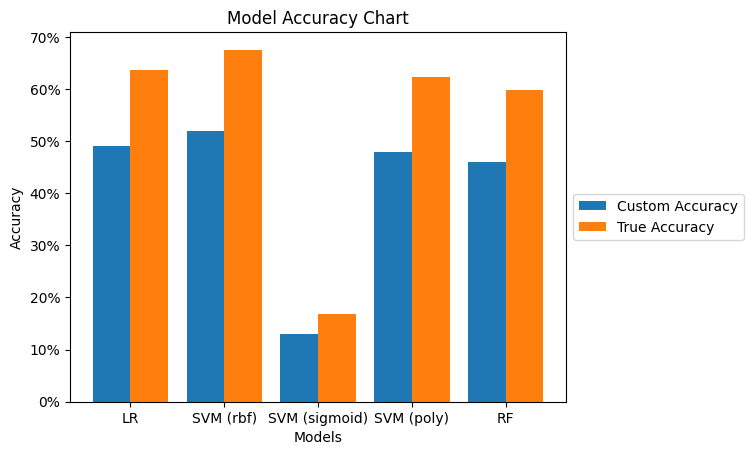

In [17]:
cats = ['LR', 'SVM (rbf)', 'SVM (sigmoid)', 'SVM (poly)', 'RF'] # categories
vals1, vals2 = [best_log_correct, best_svm_rbf_correct, best_svm_sigmoid_correct, best_svm_poly_correct, best_rf_correct], [best_log_correct / len(stars) * 100, best_svm_rbf_correct / len(stars) * 100, best_svm_sigmoid_correct / len(stars) * 100, best_svm_poly_correct / len(stars) * 100, best_rf_correct / len(stars) * 100]

# Bar width and x locations
w, x = 0.4, np.arange(len(cats))

fig, ax = plt.subplots()
ax.bar(x - w/2, vals1, width=w, label='Custom Accuracy')
ax.bar(x + w/2, vals2, width=w, label='True Accuracy')

ax.set_xticks(x)
ax.set_xticklabels(cats)
ax.set_xlabel('Models')
ax.yaxis.set_major_formatter(mtick.PercentFormatter())
ax.set_ylabel('Accuracy')
ax.set_title('Model Accuracy Chart')
ax.legend(loc='center left', bbox_to_anchor=(1, 0.5))

plt.show()

In [23]:
# tp = players correct
# fp = 100 - tp
# fn = (77 - tp)
# tn = 2395 - fn
log_tp, log_fp, log_fn, log_tn = best_log_correct, 100 - best_log_correct, len(stars) - best_log_correct, len(y_test) - 100 - (len(stars) - best_log_correct)
print("LR Confusion Matrix: ")
print(f"[{log_tp}] [{log_fp}]")
print(f"[{log_fn}] [{log_tn}]")
print(" ")

svm_rbf_tp, svm_rbf_fp, svm_rbf_fn, svm_rbf_tn = best_svm_rbf_correct, 100 - best_svm_rbf_correct, len(stars) - best_svm_rbf_correct, len(y_test) - 100 - (len(stars) - best_svm_rbf_correct)
print("SVM (rbf) Confusion Matrix: ")
print(f"[{svm_rbf_tp}] [{svm_rbf_fp}]")
print(f"[{svm_rbf_fn}] [{svm_rbf_tn}]")
print(" ")

svm_sigmoid_tp, svm_sigmoid_fp, svm_sigmoid_fn, svm_sigmoid_tn = best_svm_sigmoid_correct, 100 - best_svm_sigmoid_correct, len(stars) - best_svm_sigmoid_correct, len(y_test) - 100 -(len(stars) - best_svm_sigmoid_correct)
print("SVM (sigmoid) Confusion Matrix: ")
print(f"[{svm_sigmoid_tp}] [{svm_sigmoid_fp}]")
print(f"[{svm_sigmoid_fn}] [{svm_sigmoid_tn}]")
print(" ")

svm_poly_tp, svm_poly_fp, svm_poly_fn, svm_poly_tn = best_svm_poly_correct, 100 - best_svm_poly_correct, len(stars) - best_svm_poly_correct, len(y_test) - 100 - (len(stars) - best_svm_poly_correct)
print("SVM (poly) Confusion Matrix: ")
print(f"[{svm_poly_tp}] [{svm_poly_fp}]")
print(f"[{svm_poly_fn}] [{svm_poly_tn}]")
print(" ")

rf_tp, rf_fp, rf_fn, rf_tn = best_rf_correct, 100 - best_rf_correct, len(stars) - best_rf_correct, len(y_test) - 100 - (len(stars) - best_rf_correct)
print("RF Confusion Matrix: ")
print(f"[{rf_tp}] [{rf_fp}]")
print(f"[{rf_fn}] [{rf_tn}]")

LR Confusion Matrix: 
[49] [51]
[28] [2367]
 
SVM (rbf) Confusion Matrix: 
[52] [48]
[25] [2370]
 
SVM (sigmoid) Confusion Matrix: 
[13] [87]
[64] [2331]
 
SVM (poly) Confusion Matrix: 
[48] [52]
[29] [2366]
 
RF Confusion Matrix: 
[46] [54]
[31] [2364]


In [25]:
log_precision = []
log_recall = []
log_true_positives = 0

svm_rbf_precision = []
svm_rbf_recall = []
svm_rbf_true_positives = 0

svm_sigmoid_precision = []
svm_sigmoid_recall = []
svm_sigmoid_true_positives = 0

svm_poly_precision = []
svm_poly_recall = []
svm_poly_true_positives = 0

rf_precision = []
rf_recall = []
rf_true_positives = 0

for i in range(100):
  if (best_log_rankings[i] in stars):
    log_true_positives += 1
  log_recall.append(log_true_positives / (log_tp + log_fn))
  log_precision.append(log_true_positives / (i + 1))

  if (best_svm_rbf_rankings[i] in stars):
    svm_rbf_true_positives += 1
  svm_rbf_recall.append(svm_rbf_true_positives / (svm_rbf_tp + svm_rbf_fn))
  svm_rbf_precision.append(svm_rbf_true_positives / (i + 1))

  if (best_svm_sigmoid_rankings[i] in stars):
    svm_sigmoid_true_positives += 1
  svm_sigmoid_recall.append(svm_sigmoid_true_positives / (svm_sigmoid_tp + svm_sigmoid_fn))
  svm_sigmoid_precision.append(svm_sigmoid_true_positives / (i + 1))

  if (best_svm_poly_rankings[i] in stars):
    svm_poly_true_positives += 1
  svm_poly_recall.append(svm_poly_true_positives / (svm_poly_tp + svm_poly_fn))
  svm_poly_precision.append(svm_poly_true_positives / (i + 1))

  if (best_rf_rankings[i] in stars):
    rf_true_positives += 1
  rf_recall.append(rf_true_positives / (rf_tp + rf_fn))
  rf_precision.append(rf_true_positives / (i + 1))


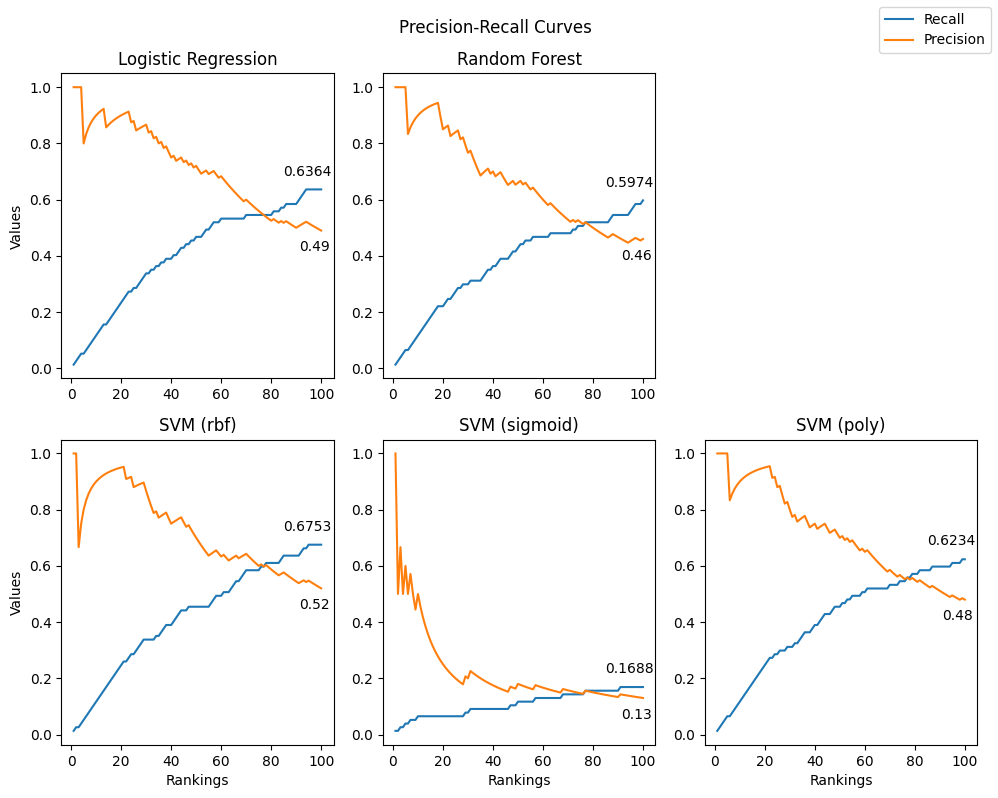

In [96]:
x = list(range(1,101))
fig, ((ax1, ax2, ax3), (ax4, ax5, ax6)) = plt.subplots(nrows=2,ncols=3, figsize = (10, 8))
fig.suptitle('Precision-Recall Curves')
ax1.set_title('Logistic Regression')
ax1.set_ylabel("Values")
ax1.plot(x, log_recall)
ax1.plot(x, log_precision)
ax1.annotate(f'{log_recall[-1]:.4f}', (x[-1], log_recall[-1]), textcoords="offset points", xytext=(-10,10), ha='center')
ax1.annotate(f'{log_precision[-1]}', (x[-1], log_precision[-1]), textcoords="offset points", xytext=(-5,-15), ha='center')
ax2.set_title('Random Forest')
ax2.plot(x, rf_recall)
ax2.plot(x, rf_precision)
ax2.annotate(f'{rf_recall[-1]:.4f}', (x[-1], rf_recall[-1]), textcoords="offset points", xytext=(-10,10), ha='center')
ax2.annotate(f'{rf_precision[-1]}', (x[-1], rf_precision[-1]), textcoords="offset points", xytext=(-5,-15), ha='center')
ax3.axis('off')
ax4.set_title('SVM (rbf)')
ax4.set_ylabel("Values")
ax4.set_xlabel("Rankings")
ax4.plot(x, svm_rbf_recall)
ax4.plot(x, svm_rbf_precision)
ax4.annotate(f'{svm_rbf_recall[-1]:.4f}', (x[-1], svm_rbf_recall[-1]), textcoords="offset points", xytext=(-10,10), ha='center')
ax4.annotate(f'{svm_rbf_precision[-1]}', (x[-1], svm_rbf_precision[-1]), textcoords="offset points", xytext=(-5,-15), ha='center')
ax5.set_title('SVM (sigmoid)')
ax5.set_xlabel("Rankings")
ax5.plot(x, svm_sigmoid_recall)
ax5.plot(x, svm_sigmoid_precision)
ax5.annotate(f'{svm_sigmoid_recall[-1]:.4f}', (x[-1], svm_sigmoid_recall[-1]), textcoords="offset points", xytext=(-10,10), ha='center')
ax5.annotate(f'{svm_sigmoid_precision[-1]}', (x[-1], svm_sigmoid_precision[-1]), textcoords="offset points", xytext=(-5,-15), ha='center')
ax6.set_title('SVM (poly)')
ax6.set_xlabel("Rankings")
ax6.plot(x, svm_poly_recall)
ax6.plot(x, svm_poly_precision)
ax6.annotate(f'{svm_poly_recall[-1]:.4f}', (x[-1], svm_poly_recall[-1]), textcoords="offset points", xytext=(-10,10), ha='center')
ax6.annotate(f'{svm_poly_precision[-1]}', (x[-1], svm_poly_precision[-1]), textcoords="offset points", xytext=(-5,-15), ha='center')

labels = ["Recall", "Precision"]

fig.tight_layout()
fig.legend(labels=labels,
           loc="upper right")

In [19]:
# Where to next?

# Ranking of top 100 (1st, 10th, unranked) - Logistic Regression sort of does this, will need to elaborate further
# Above top 25, where could they land
# Transferability (need club name)?
# Team chemistry (combine with KNN)?
# Play-by-play (+ or -)?

